In [ ]:
!pwd

In [ ]:
%reset

In [1]:
ForColab = False

In [2]:
if ForColab:
    !pip install wget
    !pip install git+https://github.com/rajeshrinet/pyross.git
    !pip install git+https://github.com/lukastk/PyRossGeo.git
    import os
    owd = os.getcwd()
    os.chdir('../../')

    import plotly.io as pio
    pio.renderers.default = 'colab'
else:
    print("Working local")

Working local


In [3]:
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 10),
         'axes.labelsize': 13,
         'axes.titlesize':13,
         'xtick.labelsize':13,
         'ytick.labelsize':13,
         'axes.labelweight':'bold',
          'legend.fontsize': 13,
         'figure.max_open_warning': 0}
         
plt.rcParams.update(params)

In [4]:
from datetime import datetime, timedelta
import os
from pathlib import Path
import pickle
from timeit import default_timer as timer
import wget
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
    
import pandas as pd
#pd.options.plotting.backend = "plotly"

import numpy as np

from tqdm.notebook import tqdm

from scipy.integrate import odeint, solve_ivp
from scipy.optimize import minimize,curve_fit

from sklearn.metrics import mean_squared_log_error, mean_squared_error

from PIL import Image

#import chart_studio
#chart_studio.tools.set_config_file(world_readable=False)

#import chart_studio.plotly as ply


import pyross, pyrossgeo

In [5]:
def plot_model(Data,  ICUHospital, title):

    S  = model.S(Data)
    Ia = model.Ia(Data)
    Is = model.Is(Data)
    R  = model.R(Data)

    InfectedCases = Ia+Is

    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))
    fig, ax1 = plt.subplots(1, 1)
    fig.suptitle(title)

    ax1.plot(S, 'tab:blue', label='Susceptible');
    ax1.plot(Ia, 'tab:orange', label='Exposed');
    ax1.plot(Is, 'tab:red', label='Infected');
    ax1.plot(R, 'tab:green', label='Recovered');
    #ax1.plot(InfectedCases, 'tab:purple', label='Hospitalised');
    #ax1.plot(crit, 'tab:brown', label='Critical');
    #ax1.plot(death, 'tab:cyan', label='Deceased');
    #ax1.hlines(np.mean([SAHospital[1][0],SAHospital[1][1]]),0,len(sus),linestyles='dashed',
    #           label="Mean ICU beds")


    ax1.semilogy()

    ax1.set_xlabel("Days");
    ax1.legend(loc='best');
    ax1.set_ylabel("No of people");
    '''        
    ax2.plot(cases, 'tab:red', label='Cases');    
    ax2.set_xlabel("Days", fontsize=10);
    ax2.semilogy()

    ax3 = ax2.twinx()
    ax3.plot(death, 'tab:cyan', label='Deceased');    
    ax3.set_xlabel("Days", fontsize=10);
    ax3.semilogy()
    '''

    '''
    ax2.set_ylabel("No of population (Cases)", fontsize=10, color='tab:red');
    ax3.set_ylabel("No of population (Fatalities)", fontsize=10, color='tab:cyan');
    '''        

    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),ncol=3, fancybox=True, shadow=True)

In [6]:
NZA = 59156682 # Total South Africa population

# Getting Covid values for cases in SA for each province 

In [7]:
def get_SA_province(ToUpdateSAProvince):
    
    '''
    This function will get the SA provincial confirmed and cases as function of date
    It also has the total that should agree with the reported worldodometer confirmed cases
    
    Usage:
    
        get_SA_province('y') or get_SA_province('n')
    
    Input:
        Take a y or n - whether to update the dataset or not
    
    Output:
        Returns the SA province confirmed dataframe
    '''
    
    import pandas as pd
    import wget
    import ssl
    ssl._create_default_https_context = ssl._create_unverified_context

    if ToUpdateSAProvince.lower() =='y':
        
        print("updating data")
        ConfirmedURL = "https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv"
        SAProvinConfirmed = pd.read_csv(wget.download(ConfirmedURL, out ='covid19za_provincial_cumulative_timeline_confirmed.csv'))
        DeathURL = "https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_deaths.csv"
        SAProvinDead = pd.read_csv(wget.download(DeathURL, out= 'covid19za_provincial_cumulative_timeline_deaths.csv'))
        RecoveredURL = "https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_recoveries.csv"
        SAProvinrecover = pd.read_csv(wget.download(DeathURL, out ='covid19za_provincial_cumulative_timeline_recoveries.csv'))
        
    else:
        print("Reading local file... Please check data is uptodate")
        SAProvinConfirmed  = pd.read_csv("covid19za_provincial_cumulative_timeline_confirmed.csv")
        SAProvinDead = pd.read_csv("covid19za_provincial_cumulative_timeline_deaths.csv")
        SAProvinrecover = pd.read_csv("covid19za_provincial_cumulative_timeline_recoveries.csv")
        print(f"Note: File was last updated on {SAProvinConfirmed['date'].values[-1]}")
    #
    # Drop the unwanted column
    #
    if 'YYYYMMDD' in SAProvinConfirmed.columns:
        SAProvinConfirmed.drop(columns='YYYYMMDD', inplace = True)
        SAProvinDead.drop(columns='YYYYMMDD', inplace = True)
        SAProvinrecover.drop(columns='YYYYMMDD', inplace = True)
    #
    # Drop the source of information
    #
    if 'source' in SAProvinConfirmed.columns:
        SAProvinConfirmed.drop(columns='source', inplace = True)
        SAProvinDead.drop(columns='source', inplace = True)
        SAProvinrecover.drop(columns='source', inplace = True)
    #
    # Make the date the index
    #
    SAProvinConfirmed["date"] = pd.to_datetime(SAProvinConfirmed.date, format='%d-%m-%Y')
    SAProvinConfirmed.index = SAProvinConfirmed["date"]
    
    SAProvinDead["date"] = pd.to_datetime(SAProvinDead.date, format='%d-%m-%Y')
    SAProvinDead.index = SAProvinDead["date"]
    
    SAProvinrecover["date"] = pd.to_datetime(SAProvinrecover.date, format='%d-%m-%Y')
    SAProvinrecover.index = SAProvinrecover["date"]
    
    #
    # Deleting the date column now
    #
    SAProvinConfirmed.drop(columns='date', inplace = True)
    SAProvinDead.drop(columns='date', inplace = True)
    SAProvinrecover.drop(columns='date', inplace = True)
    #
    # Renaming the Total column to Confirmed
    #
    SAProvinConfirmed = SAProvinConfirmed.rename(columns={'total': 'Confirmed'})
    SAProvinDead = SAProvinDead.rename(columns={'total': 'Dead'})
    SAProvinrecover = SAProvinrecover.rename(columns={'total': 'Recovered'})
    #
    #
    #
    return(SAProvinConfirmed,SAProvinDead, SAProvinrecover)



In [8]:
ProvinConf, ProvinDead, ProvinRecover = get_SA_province('y') 

updating data


In [9]:
ProvinConf.dropna(inplace=True)

In [10]:
ProvinConf = ProvinConf.astype('int64')

In [11]:
ProvinConf.head()

,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,Confirmed
date,,,,,,,,,,,
2020-03-05,0,0,0,1,0,0,0,0,0,0,1
2020-03-07,0,0,1,1,0,0,0,0,0,0,2
2020-03-08,0,0,1,2,0,0,0,0,0,0,3
2020-03-09,0,0,1,6,0,0,0,0,0,0,7
2020-03-11,0,0,5,7,0,0,0,0,1,0,13


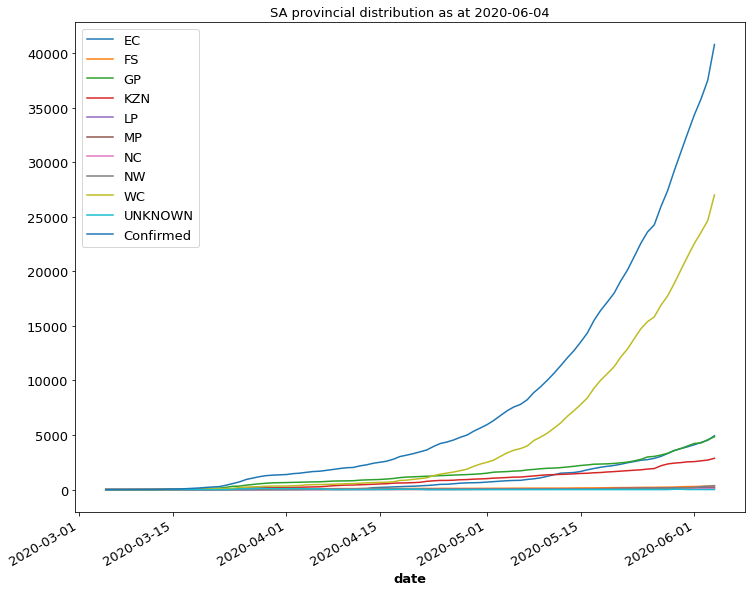

In [12]:
#ProvinConf.plot(x=ProvinConf.index, y=['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC', 'UNKNOWN'],
ProvinConf.plot(title=f"SA provincial distribution as at {ProvinConf.index[-1].date()}");


In [13]:
#ProvinConf.plot(ProvinConf,x=ProvinConf.index, y=ProvinConf['Confirmed'])

## Getting the ZA province population 

In [14]:
def get_SA_Prov_Pop(ToUpdateSAProvince):
    
    '''
    Usage:
    
        get_SA_province('y') or get_SA_province('n')
    
    This function will get the SA provincial population numbers.
    
    Input:
        Take a y or n - whether to update the dataset or not
    
    Output:
        Returns the SA province population dataframe
    '''
    
    import pandas as pd
    import wget
    import ssl
    ssl._create_default_https_context = ssl._create_unverified_context

    if ToUpdateSAProvince.lower() =='y':
        
        print("updating data")
        ConfirmedURL = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/district_data/za_province_pop.csv'
        SAProvinPop = pd.read_csv(wget.download(ConfirmedURL, out='za_province_pop.csv'),header=None)
        SAProvinPop.columns = ['Province', 'Pop']

    return(SAProvinPop)


In [15]:
SAProvPop = get_SA_Prov_Pop('y')

updating data


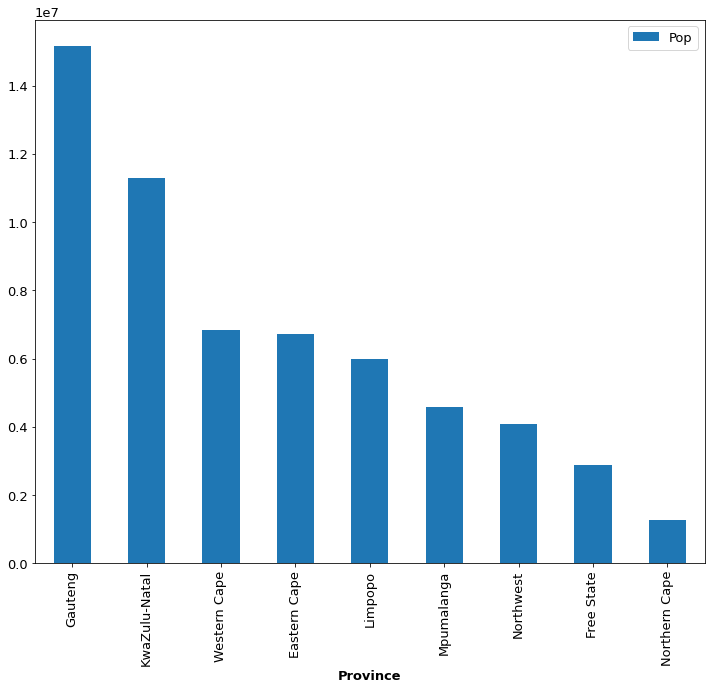

In [16]:
SAProvPop.plot(kind='bar',x='Province',y='Pop')

## Getting the Rt calculate values for each province

In [17]:
#
# Taken from Felix updated notebook
#
def get_Rt_lm(DFSeries):
    '''
    This function will calculate the value of Rt for a series.
    In order to calculate R0 we can adapt this 
    https://en.wikipedia.org/wiki/Basic_reproduction_number#Estimation_methods

    Reminder: Rt = R0 when no intervention has been applied and there is mixing
    
    usage get_Rt(pandas_series)
    
    Input:
        Take in a pandas series with time and value
    Output:
        Return the value of R0
    In addition we use a different fitting approach than above
    '''
    import numpy as np
    from lmfit import minimize, Parameters, report_fit # added by [NO]
    
    params = Parameters()
    params.add('a', value=0.)
    params.add('b', value=0.)
    def get_residuals(params, x, data):
      a=params['a'].value
      b=params['b'].value
      model = a * np.exp(b*x)
      return data - model
    x = np.arange(len(DFSeries))
    data = list(DFSeries.values)
    out = minimize(get_residuals,params, args = (x,data))
    a = out.params['a'].value
    b = out.params['b'].value
    sigma_b = out.params['b'].stderr
    
    #a = LogisticFit[0][0]
    #b = LogisticFit[0][1] # This is also known as K from description in Wikipedia
    #
    # The dooubling rate is given by T_d
    #
    T_d = np.log(2)/b 
    #
    # We will use the imperial value for tau, this can change later
    #
    tau = 5.1 
    sigma_Rt = (np.exp(b*tau)) * (np.sinh(tau*sigma_b)) #obtaining error for Rt based on error in b
    Rt = np.mean(np.exp(b*tau))
    
    #report_fit(out) # added by [NO]
    
    return (Rt , sigma_Rt)

In [18]:
# To updated Rt based on the exponential fit parameters we run this function after updating the dataframes
Recent_prov_Rt = {i: get_Rt_lm(ProvinConf.tail(14)[i]) for i in ProvinConf.columns}

In [21]:
Recent_prov_Rt

{'EC': (1.3221295554208243, 0.009041033135357705),
 'FS': (1.2642614395548462, 0.014268026278152135),
 'GP': (1.2922144338622958, 0.006655927360490546),
 'KZN': (1.2214001591152501, 0.016032211671960787),
 'LP': (1.2632518690412604, 0.01597968584998862),
 'MP': (1.1761927247857884, 0.012054249383896917),
 'NC': (1.533976988801196, 0.046686690908126834),
 'NW': (1.9601342748376813, 0.09472253885896699),
 'WC': (1.3262619342995963, 0.006355002513901561),
 'UNKNOWN': (1.4689201337498605, 0.9328316707093344),
 'Confirmed': (1.3144026798541677, 0.005523518872580347)}

# SEAI8R

## Description of the model: 


![Screenshot_2020-05-13_at_13.54.00](https://gitlab.com/camsofties/covid19//uploads/55279e434788919018151d4793bb11f0/Screenshot_2020-05-13_at_13.54.00.png)


In this model we are still using an SIR except that we added an Exposed (E), Activated (A) compartment.

- The activated compartment holds the population of cases that are asymptomatic and infectious.

The following parameters are used in this model:

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), 
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals), 
* $\gamma_\mathrm{E}$ (rate of exposed -> activated), 
* $\gamma_\mathrm{A}$ (rate of activated -> infected, symptomatic or asymptomatic)
* $\mathrm{hh}$ (rate of infected -> hospitalised)



# Doing a more complex model now pyross.deterministic.SEAI8R for ZA


## 1 - Define model

In [ ]:
PyROSSPATH = pyross.__path__[0]

In [ ]:
PyROSSPATH

In [ ]:
!pwd

In [ ]:
PyROSSAgePATH = '/home/ubuntu/DS/COVID/pyross/examples/data/age_structures/'

### 1.1 - Set up age group

In [ ]:
def AgeClass(AgeMat, ToDoAge):
    '''
    This function will return the Age matrix
    Input:
        M - number of age classes
        AgeMat - matrix holding the age classes
    OutPut:
        N - total population is the size of this age group
    '''
    #
    # population and age classes
    #
    if ToDoAge:
        
        print("#####\n Age classes has been selected \n#####")
        M     = len(AgeMat)                           # number of age classes, here taking all 21
        Ni    = AgeMat['M'].values+AgeMat['F'].values # aM, aF - age male and age female
        Ni    = Ni[0:M]                               # Give the total population in each age group
        N     = np.sum(Ni)                            # Getting the total population of country

    else:
        print("#####\n NO age classes has been selected \n#####")
        M     = 1                                     # Number of compartments of individual for each class,
                                                      # the SIR model has no age structure for now
        Ni    = NZA*np.ones(M)                        # Initial number in each compartment and class
        N     = np.sum(Ni)                            # and the total population is the size of this age group
    
    return(M, Ni, N)

In [ ]:
#
# loading ZAage structure, if not available locally will pull from the github repo
#
try:
    AgeZA = pd.read_csv(PyROSSAgePATH+'SouthAfrica-2019.csv')
except:
    print("Loading data from github repo")
    URL = 'https://raw.githubusercontent.com/ifornax/Covid19/master/SouthAfrica-2019.csv'
    AgeZA = pd.read_csv(wget.download(URL, out='SouthAfrica-2019.csv'),header=None)

M, Ni, N = AgeClass(AgeZA, False)

In [ ]:
print(f"Number of classes = {M} \nNumber Population in each age group {Ni[0]} \nTotal population is {N}")

### 1.2 - Set up the contact Matrix

In [ ]:
ToDoContact = False
#
# ToDo a contactmatrix for SouthAfrica provinces
#
# pyross.contactMatrix.ContactMatrixFunction?
# CH:  constant matrix at home
# CW:  constant matrix at work
# CS:  constant matrix at school
# CO:  constant matrix at other locations
#

Tf = 240                              # reference trajectory is 240 days long
Nf = 600                     
times = [21, Tf]                      # temporal boundaries between different contact-behaviour


if ToDoContact:
    #
    # Get individual contact matrices
    #
    #CH, CW, CS, CO = pyross.contactMatrix.India()
    url = 'https://raw.githubusercontent.com/sillsphelyx/Pyross-SA-contact-matrices/master/CH.csv'
    CH = np.genfromtxt((wget.download(url, out = 'CH.csv')),delimiter = ',' ,skip_header = 0)
    url = 'https://raw.githubusercontent.com/sillsphelyx/Pyross-SA-contact-matrices/master/CH.csv'
    CW = np.genfromtxt((wget.download(url, out = 'CW.csv')),delimiter = ',' ,skip_header = 0)
    url = 'https://raw.githubusercontent.com/sillsphelyx/Pyross-SA-contact-matrices/master/CH.csv'
    CS = np.genfromtxt((wget.download(url, out = 'CS.csv')),delimiter = ',' ,skip_header = 0)
    url = 'https://raw.githubusercontent.com/sillsphelyx/Pyross-SA-contact-matrices/master/CH.csv'
    CO = np.genfromtxt((wget.download(url, out = 'CO.csv')),delimiter = ',' ,skip_header = 0)

    #
    # Generate class with contact matrix for SIR model with South Africa contact structure
    #
    generator = pyross.contactMatrix.ContactMatrixFunction(CH, CW, CS, CO)


    aW, aS, aO = 0.3, 0.2, 0.8

    # prefactors for CW, CS, CO:
    interventions = [[1.0,1.0,1.0],      # before first time
                     [aW, aS, aO],       # between first and second time
                    ]         

    # generate corresponding contact matrix function
    contactMatrix = generator.interventions_temporal(times=times,interventions=interventions)
    
else:
    def contactMatrix(t):   
        return np.identity(M)

### 1.3 - Parameters of trajectory

In [ ]:
#
# Model parameters set up
#
alpha = 0.75                 # fraction of infected who are asymptomatic

#beta  = 0.5                # Uncomment to use infection rate for South Africa from 
                            # https://www.medrxiv.org/content/10.1101/2020.04.18.20070771v2
                            # beta = Rt/tinf
Rt    = 2.4                 # using the value we used in our original model
tinf  = 6.1                 # infectious time
beta  = Rt/tinf

#gE    = 1./2.72            # rate of removal of Exposed
gE    = 1./5.1              # rate of removal of Exposed, aka 1/t_incu 
gA    = 1./3.12             # rate of removal of Activated
gIa   = 1./7.               # rate of removal of asymptomatic infectives 
gIs   = 1./4.82             # rate of removal of symptomatic infectives 

fsa   = 1.                  # the self-isolation parameter   
fh    = 0.2                 # fraction by which hospitalised individuals are isolated
gIh   = 1./10.              # rate of removal for hospitalised individuals
gIc   = 1./10.              # rate of removal for idividuals in intensive care
 
gIsp  = 1./7.               # rate of removal from symptomatic individuals towards buffer
gIhp  = 1./7.               # rate of removal from hospitalised individuals towards buffer
gIcp  = 1./7.               # rate of removal from ICU individuals towards buffer

In [ ]:
#
# The following parameters are not varying for now
#

In [ ]:
sa   = 0.2*np.ones(M)       # daily arrival of new susceptables - 
                            # sa is rate of additional/removal of population by birth etc
hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital
cc   = 0.05*np.ones(M)      # fraction sent to ICU from hospitalised
mm   = 0.8*np.ones(M)       # mortality rate in ICU, aka IFR !!!


### 1.4 - Initial conditions    


In [ ]:

DateToStart = '2020-05-01'     # Date to start the prediction 


In [ ]:

#E_0   = np.zeros((M))

A_0   = np.zeros((M))

#Ia_0  = 1000*np.ones((M))            # assume 1000 asymptomatic cases 
                                      # 5-80% https://www.cebm.net/covid-19/covid-19-what-proportion-are-asymptomatic/
frac_asymptomatic = alpha

#n_tested_active   = 4502              # total cases - recovered: 5951 - 2498
n_tested_active   = ProvinConf[ProvinConf.index == DateToStart]['Confirmed'].values[0]- \
                    ProvinRecover[ProvinRecover.index == DateToStart]['Recovered'].values[0]
Ia_0              = (n_tested_active * (1/(1-frac_asymptomatic)))*np.ones((M)) 


E_0   = Ia_0 * 1.7                     # (R_t^(time from infection to test)/t_inf ~ 2)*n_infected

#Is_0  = np.zeros((M))                 # initial symptomatic cases
Is_0  = ProvinConf[ProvinConf.index == DateToStart]['Confirmed'].values[0]*np.ones((M))

Isp_0 = np.zeros((M))

#Ih_0  = np.zeros((M))                 # initial hospitalised cases
Ih_0  = 140*np.ones((M))               # can put each province number hereon
Ihp_0 = np.zeros((M))

#Ic_0  = np.zeros((M))                 # initial icu patients
Ic_0  = 70*np.ones((M))                # can put each province number hereon
Icp_0 = np.zeros((M))

#Im_0  = np.zeros((M))                 # initial mortality cases
Im_0  = ProvinDead[ProvinDead.index == DateToStart]['Dead'].values[0]*np.ones((M))

#R_0   = np.zeros((M))                 # assume no removed individuals
#n_recovered = (n_total_cases - n_tested_active) * (1/(1-frac_asymptomatic))
R_0   = (ProvinConf[ProvinConf.index == DateToStart]['Confirmed'].values[0] - n_tested_active)*\
        (1/(1-frac_asymptomatic))*np.ones(M)

S_0   = Ni - (E_0 + A_0 + Ia_0 + Is_0 + Isp_0+ Icp_0+ Ihp_0 + Ih_0 + Ic_0  + R_0)


## 2 - Use pyross to generate model

- In or model we are interested in the population of cases which are critical, we can either use a SEAI8R or SEA5IR
- The major differences is that the SEAI8R model has 3 ganular compartments of Symptomatic, Hospitalised and ICU
cases that recover. Each will have a separate compartment.

- We will look at both the SEAI8R and SEAI5R model

### 2.1 - SEAI8R model (This is for testing and adapting)

In [ ]:
#
# intantiate model
#
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 'gIsp':gIsp, 'gIcp':gIcp, 'gIhp':gIhp,
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}
model = pyross.deterministic.SEAI8R(parameters, M, Ni)
data  = model.simulate(S_0, E_0, A_0, Ia_0, Is_0, Isp_0, Ih_0, 
                       Ih_0, Ic_0, Icp_0, Im_0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('Deterministic_Trajectory.npy', data_array) # this is needed in the inference part later

### 2.1.1 - Intermediate SEAI8R visualization

In [ ]:
#
# plot the stochastic solution 
#
fig,ax = plt.subplots(1,1, dpi=80, facecolor='w', edgecolor='k')

S = model.S(data);
E = model.E(data);
A = model.A(data);

Ia = model.Ia(data);
Is = model.Is(data);
Im = model.Im(data);
Ih = model.Ih(data);
Ic = model.Ic(data);

Itotal = Ia+Is

R = model.R(data);

#cases = (inf + rec + hosp + crit + death)
TotalCases = (Is + R + Ih + Im)

#ax.plot(data['t'], S.sum(axis=1), lw=3, label='S - Suceptible')
#ax.plot(data['t'], E.sum(axis=1), lw=3, label='E - Exposed')
#ax.plot(data['t'], A.sum(axis=1), lw=3, label='A - Activated')
#ax.plot(data['t'], Ia.sum(axis=1), lw=3, label='Ia - Infected Asymptomatic')
#ax.plot(data['t'], Is.sum(axis=1), lw=3, label='Is - Infected Symptomatic')
ax.plot(data['t'], Im.sum(axis=1), lw=3, label='Im - Fatality')
ax.plot(data['t'], Ih.sum(axis=1), lw=3, label='Ih - Hospitalised')
ax.plot(data['t'], Ic.sum(axis=1), lw=3, label='Ic - Critical/ICU')
#ax.plot(data['t'], Itotal.sum(axis=1), lw=3, label='It - Total Infected')
#ax.plot(data['t'], R.sum(axis=1), lw=3, label='R - Total Recovered')
ax.plot(data['t'], TotalCases.sum(axis=1), lw=3, label='Cases - Total Cases')


ax.set_xlabel(f"Time [No. days from {DateToStart}]")
ax.set_ylabel('Populations')
#ax.set_title('SEAI8R model')

#ax2 = ax.twiny()
#ax2.set_xlabel("Date")
    
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),ncol=3, fancybox=True, shadow=True)
plt.semilogy()
plt.savefig('PyROSS_SEAI8R_SEIRHCD.png')
plt.show()
plt.close()

### 2.2 - SEAI5R model

In [ ]:
#
# intantiate model
#
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 'gIsp':gIsp, 'gIcp':gIcp, 'gIhp':gIhp,
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}
model = pyross.deterministic.SEAI5R(parameters, M, Ni)
data  = model.simulate(S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('SEAI5R_Deterministic_Trajectory.npy', data_array) # this is needed in the inference part later

In [ ]:
for key in data.keys():
    print(key)

In [ ]:
#
# plot the stochastic solution 
#
fig,ax = plt.subplots(1,1, dpi=80, facecolor='w', edgecolor='k')

S = model.S(data);
E = model.E(data);
A = model.A(data);

Ia = model.Ia(data);
Is = model.Is(data);
Im = model.Im(data);
Ih = model.Ih(data);
Ic = model.Ic(data);

R = model.R(data);
#
# TotalCases = (inf + rec + hosp + crit + death)
#
TotalCases = (Is + R + Ih + Im)

#ax.plot(data['t'], S.sum(axis=1), lw=3, label='S - Suceptible')
#ax.plot(data['t'], E.sum(axis=1), lw=3, label='E - Exposed')
#ax.plot(data['t'], A.sum(axis=1), lw=3, label='A - Activated')
#ax.plot(data['t'], Ia.sum(axis=1), lw=3, label='Ia - Infected Asymptomatic')
#ax.plot(data['t'], Is.sum(axis=1), lw=3, label='Is - Infected Symptomatic')
ax.plot(data['t'], Im.sum(axis=1), lw=3, label='Im - Fatality')
ax.plot(data['t'], Ih.sum(axis=1), lw=3, label='Ih - Hospitalised')
ax.plot(data['t'], Ic.sum(axis=1), lw=3, label='Ic - Critical/ICU')
#ax.plot(data['t'], Itotal.sum(axis=1), lw=3, label='It - Total Infected')
#ax.plot(data['t'], R.sum(axis=1), lw=3, label='R - Total Recovered')
ax.plot(data['t'], TotalCases.sum(axis=1), lw=3, label='Cases - Total Cases')


ax.set_xlabel(f"Time [No. days from {DateToStart}]")
ax.set_ylabel('Populations')
#ax.set_title('SEAI8R model')

#ax2 = ax.twiny()
#ax2.set_xlabel("Date")
    
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),ncol=3, fancybox=True, shadow=True)
plt.semilogy()
plt.savefig('PyROSS_SEAI5R_SEIRHCD.png')
plt.show()
plt.close()

# Below this cell can be very computer intensive 

### Here we, will create and array with the parameters from an ensemble similar to what we did for the National model.

In [ ]:
#
# Model parameters set up, each parameter names will be a column and the number of ensemble will be the rows
#
def ToEnsemble(NoIteration, ProvinceRt):

    alpha  = []
    Rt     = [] ; tinf   = [] ; beta   = []
    t_incu = []
    gE     = []; gA     = []; gIa    = []; gIs    = []
    fsa    = []; fh     = []
    gIh    = []; gIc    = []; gIsp   = []; gIhp   = []; gIcp   = []

    for i in range(NoIteration):

        alpha_tmp = np.minimum(0.96, np.random.normal(0.75, 0.15))
        alpha.append(alpha_tmp)                         # fraction of infected who are asymptomatic

        #beta  = 0.5                               # Uncomment to use infection rate for South Africa from 
                                                   # https://www.medrxiv.org/content/10.1101/2020.04.18.20070771v2
                                                   # beta = Rt/tinf
        Rt_tmp = ProvinceRt*np.random.normal(1.0, 0.03)
        Rt.append(Rt_tmp)                          # using the value we used in our original model

        tinf_tmp = np.maximum(2, np.random.normal(8.15, 1.15))
        tinf.append(tinf_tmp)                      # infectious time
        beta.append(Rt_tmp/tinf_tmp)

        t_incu_tmp = 5.1
        t_incu.append(t_incu_tmp)
        gE.append(1./t_incu_tmp)                   # rate of removal of Exposed, aka 1/t_incu 

        gA_tmp = 3.12
        gA.append(1./gA_tmp)                       # rate of removal of Activated
        gIa_tmp = 7.
        gIa.append(1./gIa_tmp)                     # rate of removal of asymptomatic infectives 
        gIs_tmp = 4.82
        gIs.append(1./gIs_tmp)                     # rate of removal of symptomatic infectives 


        fsa    = 1.                                # the self-isolation parameter   
        fh     = 0.2                               # fraction by which hospitalised individuals are isolated

        gIh_tmp = np.maximum(3, np.random.normal(10.4, 4))
        gIh.append(1./gIh_tmp)                     # rate of removal for hospitalised individuals
        gIc_tmp = np.maximum(3, np.random.normal(10.4, 4))
        gIc.append(1./gIc_tmp)                     # rate of removal for idividuals in intensive care

        gIsp_tmp = 7.
        gIsp.append(1./gIsp_tmp)                   # rate of removal from symptomatic individuals towards buffer

        gIhp_tmp = np.maximum(3, np.random.normal(10.4, 4))
        gIhp.append(1./gIhp_tmp)                   # rate of removal from hospitalised individuals towards buffer

        gIcp_tmp = np.maximum(3, np.random.normal(10, 2))
        gIcp.append(1./gIcp_tmp)                   # rate of removal from ICU individuals towards buffer


    ModelParamDf = pd.DataFrame({'alpha':alpha,'Rt': Rt, 'tinf': tinf, 'beta':beta, 't_incu':t_incu,
                                 'gE': gE, 'gA': gA, 'gIa':gIa, 'gIs':gIs,'fsa':fsa, 
                                 'fh':fh, 'gIh':gIh,'gIc':gIc, 'gIsp':gIsp, 'gIhp':gIhp, 
                                 'gIcp':gIcp}, 
                                columns = ['alpha', 'Rt', 'tinf', 'beta', 't_incu', 
                                           'gE', 'gA', 'gIa', 'gIs', 'fsa', 'fh', 'gIh',
                                           'gIc', 'gIsp', 'gIhp', 'gIcp'])
    return(ModelParamDf)

In [ ]:
#
# This is testing for National values, change Rt initial if required
# 
Nums = 1000
ParamDf = ToEnsemble(Nums, ProvinceRt=2.4)


In [ ]:
ParamDf.head()

In [ ]:
ParamDf.Rt.plot(kind='hist',bins=25)

## Setting the initial conditions based on the sensemble 

In [ ]:
def ToPlot(ArrayToPlot, TimeArray, title):
    '''
    
    This function will take the prediction array and produce the plots similar to the ones we have used in our report
    
    '''
    
    S = ArrayToPlot[:,:,0]
    E = ArrayToPlot[:,:,1]
    A = ArrayToPlot[:,:,2]
    Ia = ArrayToPlot[:,:,3]
    Is = ArrayToPlot[:,:,4]
    Ih = ArrayToPlot[:,:,5]
    Ic = ArrayToPlot[:,:,6]
    Im = ArrayToPlot[:,:,7]
    R = ArrayToPlot[:,:,8]

    TotalCases = (Ia + Is + Ih + Ic + Im)

    Time = data['t']

    #StartDate = datetime.strptime(DateToStart, "%Y-%m-%d")
    #datelist = pd.date_range(StartDate, periods=Tf).tolist()

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,12))

    #title='PyRoss SEI5R Model'
    # set uniform characteristics for axes
    for idx, axis in enumerate([ax1, ax2, ax3, ax4]):
        axis.set_ylim(ymin=10, ymax=NZA*1.2)
        axis.set_xlim(0, Tf)
        axis.set_yscale('log')
        axis.tick_params(axis='y', labelsize=15);
        axis.hlines([1e+03, 1e+04, 1e+05, 1e+06], xmin=0, xmax=Tf, linestyles='dotted', alpha = 0.6);


    for i in range(len(ArrayToPlot)):
        ax1.plot(TimeArray, Ic[i,:], 'tab:orange', alpha=0.1, label='Ic - Critical/ICU')
        ax2.plot(TimeArray, Im[i,:], 'tab:red', alpha=0.1, label='Im - Fatality')
        ax3.plot(TimeArray, Ih[i,:], 'dodgerblue', alpha=0.1, label='Ih - Hospitalised')
        ax4.plot(TimeArray, TotalCases[i,:], 'tab:blue', alpha=0.1, label='Cases - Total Cases')

    #ax2.plot(ProvinDead[ProvinDead.index >= DateToStart]['Dead'].values, 'k', lw=3)

    fig.suptitle(title, fontsize=16)

    ax1.set_title("Individuals in Critical State")
    ax2.set_title("Fatalities")
    ax3.set_title("Individuals in Hospital")
    ax4.set_title(("Cumulative Total Cases"))


    ax1.set_ylabel('Populations')
    ax3.set_ylabel('Populations')
    ax3.set_xlabel(f"Time [No. days from {DateToStart}]")
    ax4.set_xlabel(f"Time [No. days from {DateToStart}]")

    return()

In [ ]:
#
# Now instantiate model again 
#

In [ ]:

NoCompartment = 9
trajectories_s = np.zeros([Nums,Nf,9*M],dtype=float)

for i in range(Nums):
    print('Running simulation {0} of {1}'.format(i+1,Nums),end='\r')
    #
    # intantiate model
    #
  
    A_0   = np.zeros((M))

    #
    #Ia_0  initial asymptomatic cases
    #
                                          
    frac_asymptomatic = ParamDf['alpha'].values[i] # 5-80% https://www.cebm.net/covid-19/covid-19-what-proportion-are-asymptomatic/
    
    #
    # total cases - recovered: 5951 - 2498
    #
    n_tested_active   = ProvinConf[ProvinConf.index == DateToStart]['Confirmed'].values[0]- \
                        ProvinRecover[ProvinRecover.index == DateToStart]['Recovered'].values[0]
    
    Ia_0              = (n_tested_active * (1/(1-frac_asymptomatic)))*np.ones((M)) 

    E_0   = Ia_0 * 1.7                     # (R_t^(time from infection to test)/t_inf ~ 2)*n_infected

    #
    # initial symptomatic cases
    #
    Is_0  = ProvinConf[ProvinConf.index == DateToStart]['Confirmed'].values[0]*np.ones((M))

    Isp_0 = np.zeros((M))

    #
    # initial hospitalised cases
    #
    Ih_0  = 140*np.ones((M))               
    Ihp_0 = np.zeros((M))

    #
    # initial icu patients
    #
    Ic_0  = 70*np.ones((M))                
    Icp_0 = np.zeros((M))

    #
    # initial mortality cases
    #
    Im_0  = ProvinDead[ProvinDead.index == DateToStart]['Dead'].values[0]*np.ones((M))

    #
    # assume no removed individuals
    #
    #n_recovered = (n_total_cases - n_tested_active) * (1/(1-frac_asymptomatic))
    R_0   = (ProvinConf[ProvinConf.index == DateToStart]['Confirmed'].values[0] - n_tested_active)*\
            (1/(1-frac_asymptomatic))*np.ones(M)

    S_0   = Ni - (E_0 + A_0 + Ia_0 + Is_0 + Isp_0+ Icp_0+ Ihp_0 + Ih_0 + Ic_0  + R_0)

    parameters = {'alpha':ParamDf['alpha'].values[i],
                  'beta' :ParamDf['beta'].values[i], 
                  'gIa'  :ParamDf['gIa'].values[i],
                  'gIs'  :ParamDf['gIs'].values[i],
                  'gIh'  :ParamDf['gIh'].values[i],
                  'gIc'  :ParamDf['gIc'].values[i],
                  'gE'   :ParamDf['gE'].values[i],
                  'gA'   :ParamDf['gA'].values[i],
                  'fsa'  :ParamDf['fsa'].values[i],
                  'fh'   :ParamDf['fh'].values[i], 
                  'gIsp' :ParamDf['gIsp'].values[i], 
                  'gIcp' :ParamDf['gIcp'].values[i], 
                  'gIhp' :ParamDf['gIhp'].values[i],
                  'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}
    model = pyross.deterministic.SEAI5R(parameters, M, Ni)
    data  = model.simulate(S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0, contactMatrix, Tf, Nf)
    trajectories_s[i] = data['X']

In [ ]:
trajectories_s.shape

## Run the above model using  WC province here

In [ ]:
## Will make a function to call the model

def MyModel(NoIteration, ParamDf, M,  Tf, Nf, Ni):

    NoCompartment = 9
    trajectories_s = np.zeros([NoIteration,Nf,9*M],dtype=float)

    for i in range(NoIteration):
        print('Running simulation {0} of {1}'.format(i+1,NoIteration),end='\r')
        #
        # intantiate model
        #

        A_0   = np.zeros((M))

        #
        #Ia_0  initial asymptomatic cases
        #

        frac_asymptomatic = ParamDf['alpha'].values[i] # 5-80% https://www.cebm.net/covid-19/covid-19-what-proportion-are-asymptomatic/

        #
        # total cases - recovered: 5951 - 2498
        #
        n_tested_active   = ProvinConf[ProvinConf.index == DateToStart]['Confirmed'].values[0]- \
                            ProvinRecover[ProvinRecover.index == DateToStart]['Recovered'].values[0]

        Ia_0              = (n_tested_active * (1/(1-frac_asymptomatic)))*np.ones((M)) 

        E_0   = Ia_0 * 1.7                     # (R_t^(time from infection to test)/t_inf ~ 2)*n_infected

        #
        # initial symptomatic cases
        #
        Is_0  = ProvinConf[ProvinConf.index == DateToStart]['Confirmed'].values[0]*np.ones((M))

        Isp_0 = np.zeros((M))

        #
        # initial hospitalised cases
        #
        Ih_0  = 140*np.ones((M))               
        Ihp_0 = np.zeros((M))

        #
        # initial icu patients
        #
        Ic_0  = 70*np.ones((M))                
        Icp_0 = np.zeros((M))

        #
        # initial mortality cases
        #
        Im_0  = ProvinDead[ProvinDead.index == DateToStart]['Dead'].values[0]*np.ones((M))

        #
        # assume no removed individuals
        #
        #n_recovered = (n_total_cases - n_tested_active) * (1/(1-frac_asymptomatic))
        R_0   = (ProvinConf[ProvinConf.index == DateToStart]['Confirmed'].values[0] - n_tested_active)*\
                (1/(1-frac_asymptomatic))*np.ones(M)

        S_0   = Ni - (E_0 + A_0 + Ia_0 + Is_0 + Isp_0+ Icp_0+ Ihp_0 + Ih_0 + Ic_0  + R_0)

        parameters = {'alpha':ParamDf['alpha'].values[i],
                      'beta' :ParamDf['beta'].values[i], 
                      'gIa'  :ParamDf['gIa'].values[i],
                      'gIs'  :ParamDf['gIs'].values[i],
                      'gIh'  :ParamDf['gIh'].values[i],
                      'gIc'  :ParamDf['gIc'].values[i],
                      'gE'   :ParamDf['gE'].values[i],
                      'gA'   :ParamDf['gA'].values[i],
                      'fsa'  :ParamDf['fsa'].values[i],
                      'fh'   :ParamDf['fh'].values[i], 
                      'gIsp' :ParamDf['gIsp'].values[i], 
                      'gIcp' :ParamDf['gIcp'].values[i], 
                      'gIhp' :ParamDf['gIhp'].values[i],
                      'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}
        model = pyross.deterministic.SEAI5R(parameters, M, Ni)
        data  = model.simulate(S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0, contactMatrix, Tf, Nf)
        trajectories_s[i] = data['X']
    
    trajectories_time =  data['t']
    return(trajectories_s, trajectories_time)

# Need to extract the Rt for the province and pass it in the function below

In [ ]:
#
# First calculate ParamDf, e.g. using Rt for WC
#
ParamDf = ToEnsemble(Nums, 2.4)

In [ ]:
#SAProvPop.head

In [ ]:
province = input(f"Enter province name of [National] from above names {SAProvPop.Province.unique()}") 


In [ ]:
if province == 'National':
    Ni = np.array([NZA])
else:
    Ni = SAProvPop[SAProvPop['Province'] == province]['Pop'].values

In [ ]:
print(f"Total population in {province} = {Ni}")

In [ ]:
MyPredict, MyPredictTime = MyModel(500, ParamDf, M,  Tf, Nf, Ni)

In [ ]:
MyPredict.shape, MyPredictTime.shape

In [ ]:
ToPlot(MyPredict, MyPredictTime, province+" SEI5R prediction")

# Using the stochastic method
## Averaging over several realisations

## NB: this is quite computer intensive as it takes time to run 


In [ ]:
break

In [ ]:
#
# run 100 simulations
#
N_runs = 5

model = pyross.stochastic.SEAI5R(parameters, M, Ni)

trajectories_s = np.zeros([N_runs,Nf,9*M],dtype=float)

from numba import jit

@jit
def RunSim():
    for i in range(N_runs):
        print('Running simulation {0} of {1}'.format(i+1,N_runs),end='\r')
        cur_result = model.simulate(S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0, contactMatrix, Tf, Nf)
        trajectories_s[i] = cur_result['X']
    t_s = cur_result['t']
    return(t_s)

In [ ]:
#
# Uncomment to run, but this is very computer intensive
#
#RunSim()

In [ ]:
# Calculate mean, standard deviation, and 10 as well as 90 percent quantiles
# for
# - the number of exposed and asymptomatic infectives,
# - the number of symptomatic infectives,
# - the number of hospitalised infectives,
# - the number of infectives in ICU,
# - the number of deceased infectives

trajectories_E_A_Ia = np.zeros([N_runs,Nf],dtype=float)
trajectories_Is = np.zeros([N_runs,Nf],dtype=float)
trajectories_Ih = np.zeros([N_runs,Nf],dtype=float)
trajectories_Ic = np.zeros([N_runs,Nf],dtype=float)
trajectories_Im = np.zeros([N_runs,Nf],dtype=float)
for i,e in enumerate(trajectories_s):
    for j in range(M):
        trajectories_E_A_Ia[i] += e[:,j+1*M] + e[:,j+2*M] + e[:,j+3*M] # E + A + Ia
        trajectories_Is[i] += e[:,j+3*M] # Is
        trajectories_Ih[i] += e[:,j+4*M] # Ih
        trajectories_Ic[i] += e[:,j+5*M] # Ic
        trajectories_Im[i] += e[:,j+6*M] # Im

        
# mean and standard deviation
mean_E_A_Ia = np.mean(trajectories_E_A_Ia, axis = 0)
mean_Is = np.mean(trajectories_Is, axis = 0)
mean_Ih = np.mean(trajectories_Ih, axis = 0)
mean_Ic = np.mean(trajectories_Ic, axis = 0)
mean_Im = np.mean(trajectories_Im, axis = 0)

std_E_A_Ia = np.std(trajectories_E_A_Ia, axis = 0)
std_Is = np.std(trajectories_Is, axis = 0)
std_Ih = np.std(trajectories_Ih, axis = 0)
std_Ic = np.std(trajectories_Ic, axis = 0)
std_Im = np.std(trajectories_Im, axis = 0)


# quantiles
percentile = 10

cur_traj = trajectories_E_A_Ia
percentiles_lower_E_A_Ia = np.percentile(cur_traj,percentile,axis=0)
percentiles_upper_E_A_Ia = np.percentile(cur_traj,100-percentile,axis=0)
percentiles_median_E_A_Ia = np.percentile(cur_traj,50,axis=0)

cur_traj = trajectories_Is
percentiles_lower_Is = np.percentile(cur_traj,percentile,axis=0)
percentiles_upper_Is = np.percentile(cur_traj,100-percentile,axis=0)
percentiles_median_Is = np.percentile(cur_traj,50,axis=0)

cur_traj = trajectories_Ih
percentiles_lower_Ih = np.percentile(cur_traj,percentile,axis=0)
percentiles_upper_Ih = np.percentile(cur_traj,100-percentile,axis=0)
percentiles_median_Ih = np.percentile(cur_traj,50,axis=0)

cur_traj = trajectories_Ic
percentiles_lower_Ic = np.percentile(cur_traj,percentile,axis=0)
percentiles_upper_Ic = np.percentile(cur_traj,100-percentile,axis=0)
percentiles_median_Ic = np.percentile(cur_traj,50,axis=0)

cur_traj = trajectories_Im
percentiles_lower_Im = np.percentile(cur_traj,percentile,axis=0)
percentiles_upper_Im = np.percentile(cur_traj,100-percentile,axis=0)
percentiles_median_Im = np.percentile(cur_traj,50,axis=0)

## Plot of results from 100 deterministic simulations

In [ ]:
def plot_data(t,trajectories,mean,std,median,percentiles_lower,percentiles_upper,
             ylabel='Population'):
    #
    # Trajectories + mean and standard deviation
    #
    fig,ax = plt.subplots(1,1,figsize=(10,6))
    fig.suptitle('Trajectories, with mean and standard deviation')
    ax.fill_between(t,mean-std,mean+std,
                    color='red',alpha=0.1
                   )
    for i,e in enumerate(trajectories):
        ax.plot(t,e,
               alpha=0.3)
    ax.plot(t,mean,lw=3,color='black',label='Mean')
    ax.plot(t,mean+std,lw=2,ls='--',color='red',label='Standard deviation')
    ax.plot(t,mean-std,lw=2,ls='--',color='red')
    ax.set_xlim(np.min(t_s),np.max(t_s))
    ax.set_xlabel('Time [days]')
    ax.set_ylabel(ylabel)
    ax.legend(loc='best')
    plt.show()
    plt.close()
    #
    #
    # Trajectories + percentiles
    #
    fig,ax = plt.subplots(1,1,figsize=(10,6))
    fig.suptitle('Trajectories, with quantiles')
    ax.fill_between(t,percentiles_lower,percentiles_upper,
                    color='red',alpha=0.1
                   )
    for i,e in enumerate(trajectories):
        ax.plot(t,e,
               alpha=0.3)
    ax.plot(t,median,lw=3,color='black',
           label='Median')
    ax.plot(t,mean,lw=3,color='dodgerblue',ls='--',
           label='Mean')
    ax.plot(t,percentiles_lower,lw=2,ls='--',color='red',
           label='Quantiles')
    ax.plot(t,percentiles_upper,lw=2,ls='--',color='red')
    ax.set_xlim(np.min(t_s),np.max(t_s))
    ax.set_xlabel('Time [days]')
    ax.set_ylabel(ylabel)
    ax.legend(loc='best')
    plt.show()
    plt.close()

In [ ]:
plot_data(t_s,
          trajectories = trajectories_E_A_Ia,
          mean = mean_E_A_Ia,  std =std_E_A_Ia,
         median = percentiles_median_E_A_Ia, 
          percentiles_lower =percentiles_lower_E_A_Ia, percentiles_upper =percentiles_upper_E_A_Ia,
         ylabel=r'Exposed + asymptomatic infectives')


print("\n\n")
plot_data(t_s,
          trajectories = trajectories_Is,
          mean = mean_Is,  std =std_Is,
         median = percentiles_median_Is, 
          percentiles_lower =percentiles_lower_Is, percentiles_upper =percentiles_upper_Is,
         ylabel=r'Symptomatic infectives')


print("\n\n")
plot_data(t_s,
          trajectories = trajectories_Ih,
          mean = mean_Ih,  std =std_Ih,
         median = percentiles_median_Ih, 
          percentiles_lower =percentiles_lower_Ih, percentiles_upper =percentiles_upper_Ih,
         ylabel=r'Hospitalised')

# 3 - Run inference on the first n days

## 3.1 - Create array with first n days of data

In [ ]:
Tf_inf = 20;                         # using data for first 20 days
Nf_inf = Tf_inf + 1
N = NZA
data_inf = (data_array/N)[:Nf_inf]


# Do NOT run below

In [ ]:
break

## 3.2 - Parameters for inference

In [ ]:
ftol = 1e-1 
steps = 5
fi = np.array([0.25, 0.75])     # fraction of population in age age group
#
# initialise the estimator 
#

estimator = pyross.inference.SEAI5R(parameters, M, fi, int(N), steps)


In [ ]:
# initial
alpha_g      = 0.15
alpha_std    = 0.2
alpha_bounds = (1e-3, 0.5)

beta_g      = 0.05
beta_std    = 0.1 
beta_bounds = (1e-3, 1)

gIa_g      = 0.13
gIa_std    = 0.1 
gIa_bounds = (1e-3, 1)

gIs_g      = 0.15
gIs_std    = 0.1 
gIs_bounds = (1e-3, 1)

guess = np.array([alpha_g, beta_g, gIa_g, gIs_g])
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std])
bounds = np.array([alpha_bounds , beta_bounds , gIa_bounds , gIs_bounds])
keys = ['alpha', 'beta', 'gIa', 'gIs']

params = estimator.infer_parameters(keys, guess, stds, bounds, data_inf, Tf_inf , Nf_inf , contactMatrix ,
                                    global_max_iter=20, global_ftol_factor = 10, verbose=True)

print(params)